In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident']-2
df.gravité_accident.value_counts()
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273226 entries, 0 to 273225
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Num_Acc                             273226 non-null  int64 
 1   jour                                273226 non-null  int64 
 2   mois                                273226 non-null  int64 
 3   an                                  273226 non-null  int64 
 4   hrmn                                273226 non-null  object
 5   dep                                 273226 non-null  object
 6   agg                                 273226 non-null  int64 
 7   int                                 273226 non-null  int64 
 8   atm                                 273226 non-null  object
 9   col                                 273226 non-null  int64 
 10  lat                                 273226 non-null  object
 11  long         

KNN GRID SEARCH

Meilleurs paramètres : {'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Accuracy : 0.69
Précision : 0.66
Rappel : 0.69
F1-score : 0.66

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.74      0.87      0.80     35156
           1       0.54      0.43      0.48     16400
           2       0.35      0.06      0.11      3090

    accuracy                           0.69     54646
   macro avg       0.54      0.45      0.46     54646
weighted avg       0.66      0.69      0.66     54646



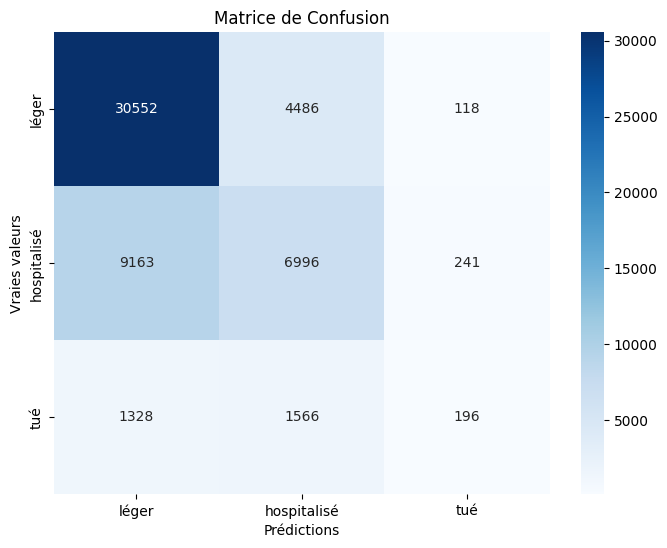

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]

# Chargement des données (Assurez-vous que df est défini)
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition des caractéristiques
categorical_features = ['agg', 'atm']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']

# Transformation des données
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features),
    ('num', StandardScaler(), passthrough_features)
])

# Définition du modèle KNN avec GridSearchCV
knn = KNeighborsClassifier()
param_grid = {'classifier__n_neighbors': [3, 5, 7, 9], 'classifier__weights': ['uniform', 'distance']}

# Pipeline avec le classificateur KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', knn)
])

# GridSearch pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Prédictions
y_pred = best_model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


KNN avec scoring pour améliorer le F1 score

F1-score moyen pour la classe 1 : 0.4686
F1-score de la classe 1 sur l'ensemble de test : 0.4751

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.75      0.85      0.79     35156
           1       0.52      0.44      0.48     16400
           2       0.28      0.06      0.10      3090

    accuracy                           0.68     54646
   macro avg       0.51      0.45      0.46     54646
weighted avg       0.65      0.68      0.66     54646



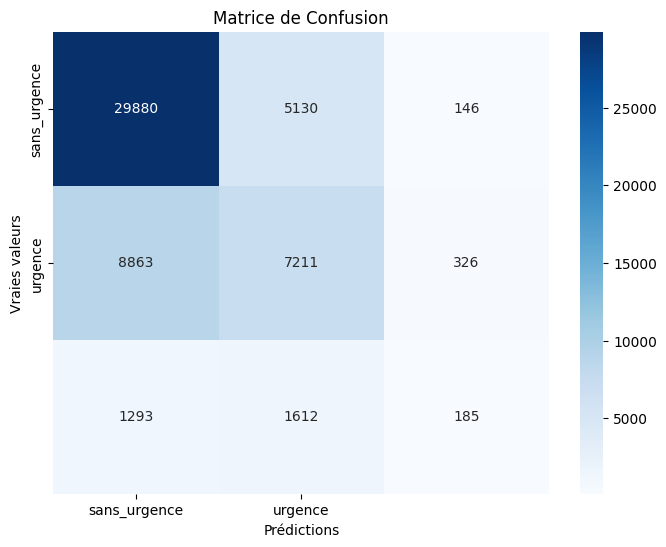

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier

# ==========================
# 1️⃣ Transformation des Données
# ==========================
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Chargement des données (remplace par ton DataFrame réel)
df = pd.read_csv("ton_fichier.csv")  # Remplace par le vrai fichier

# Séparation des features et du target
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Décalage des labels (classes 2,3,4 deviennent 0,1,2)
y = y - 2

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Variables catégorielles et cycliques
categorical_features = ['agg', 'atm']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                        'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                        '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                        'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']

# Transformation des données
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features),
    ('scaler', StandardScaler(), passthrough_features)  # Normalisation pour KNN
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# ==========================
# 2️⃣ Application de SMOTE pour équilibrer les classes
# ==========================
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# ==========================
# 3️⃣ Définition de la Métrique Personnalisée (F1-score pour une classe cible)
# ==========================
def f1_class_specific(y_true, y_pred, target_class=1):
    """
    Fonction pour calculer le F1-score d'une classe spécifique.
    """
    y_pred = (y_pred == target_class).astype(int)
    y_true = (y_true == target_class).astype(int)
    return f1_score(y_true, y_pred)

# Scorer pour GridSearchCV
f1_scorer = make_scorer(f1_class_specific, greater_is_better=True, target_class=1)

# ==========================
# 4️⃣ Entraînement du Modèle KNN avec GridSearchCV
# ==========================
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    knn_model, param_grid, scoring=f1_scorer,
    cv=3, n_jobs=-1, verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

# ==========================
# 5️⃣ Évaluation sur l'Ensemble de Test
# ==========================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)

# Calcul du F1-score pour la classe cible
f1_test = f1_score(y_test == 1, y_pred == 1)
print(f"F1-score de la classe cible (accidents graves) sur test : {f1_test:.4f}")

# ==========================
# 6️⃣ Affichage de la Matrice de Confusion
# ==========================
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion - KNN")
plt.show()

# Rapport de classification complet
print(classification_report(y_test, y_pred, target_names=["léger", "hospitalisé", "tué"]))


KNN avec scoring pour améliorer le recall